In [172]:
import sklearn
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import requests
from pathlib import Path
import numpy as np

In [173]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

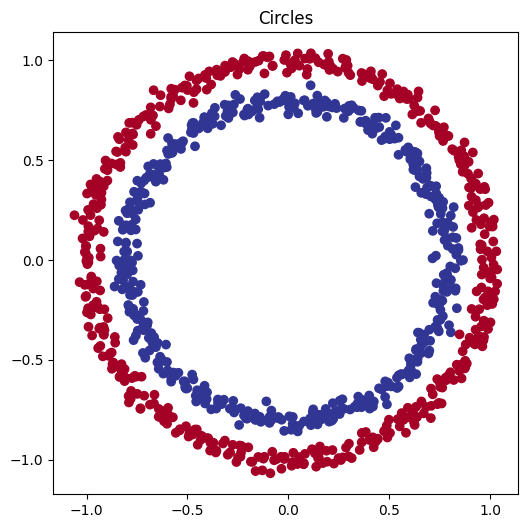

In [174]:
X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.figure(figsize=(6, 6))
plt.title("Circles")
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [175]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [177]:
class CircleModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128, out_features=256),
        nn.GELU(),
        nn.Linear(in_features=256, out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_0 = CircleModelV1(2, 1).to(device)
model_0_str = str(model_0)
model_0_cleaned = model_0_str.replace("(", " ").replace(")", " ")

In [178]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1) # set learning rate from 0.01 to 0.1
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc
optimizer_class_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]["lr"]

In [179]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs_count = []
loss_values = []
acc_values = []
test_loss_values = []
test_acc_values = []


epochs = 1000

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()

    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 50 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      acc_values.append(acc)
      test_loss_values.append(test_loss)
      test_acc_values.append(test_acc)

      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69287 | Acc: 50.00 | Test Loss: 0.69316 | Test Acc: 50.00
Epoch: 50 | Loss: 0.69188 | Acc: 56.00 | Test Loss: 0.69256 | Test Acc: 49.00
Epoch: 100 | Loss: 0.69096 | Acc: 56.12 | Test Loss: 0.69201 | Test Acc: 49.50
Epoch: 150 | Loss: 0.68990 | Acc: 55.75 | Test Loss: 0.69137 | Test Acc: 50.00
Epoch: 200 | Loss: 0.68861 | Acc: 55.88 | Test Loss: 0.69058 | Test Acc: 51.50
Epoch: 250 | Loss: 0.68699 | Acc: 56.62 | Test Loss: 0.68957 | Test Acc: 51.00
Epoch: 300 | Loss: 0.68486 | Acc: 57.00 | Test Loss: 0.68818 | Test Acc: 51.00
Epoch: 350 | Loss: 0.68196 | Acc: 57.50 | Test Loss: 0.68622 | Test Acc: 51.50
Epoch: 400 | Loss: 0.67787 | Acc: 58.50 | Test Loss: 0.68324 | Test Acc: 52.00
Epoch: 450 | Loss: 0.67178 | Acc: 60.00 | Test Loss: 0.67842 | Test Acc: 54.00
Epoch: 500 | Loss: 0.66210 | Acc: 66.50 | Test Loss: 0.67011 | Test Acc: 60.00
Epoch: 550 | Loss: 0.64536 | Acc: 83.38 | Test Loss: 0.65494 | Test Acc: 82.50
Epoch: 600 | Loss: 0.61353 | Acc: 90.50 | Test Loss: 0.

In [180]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py exists!")
else:
  print("Download helper_function.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py exists!


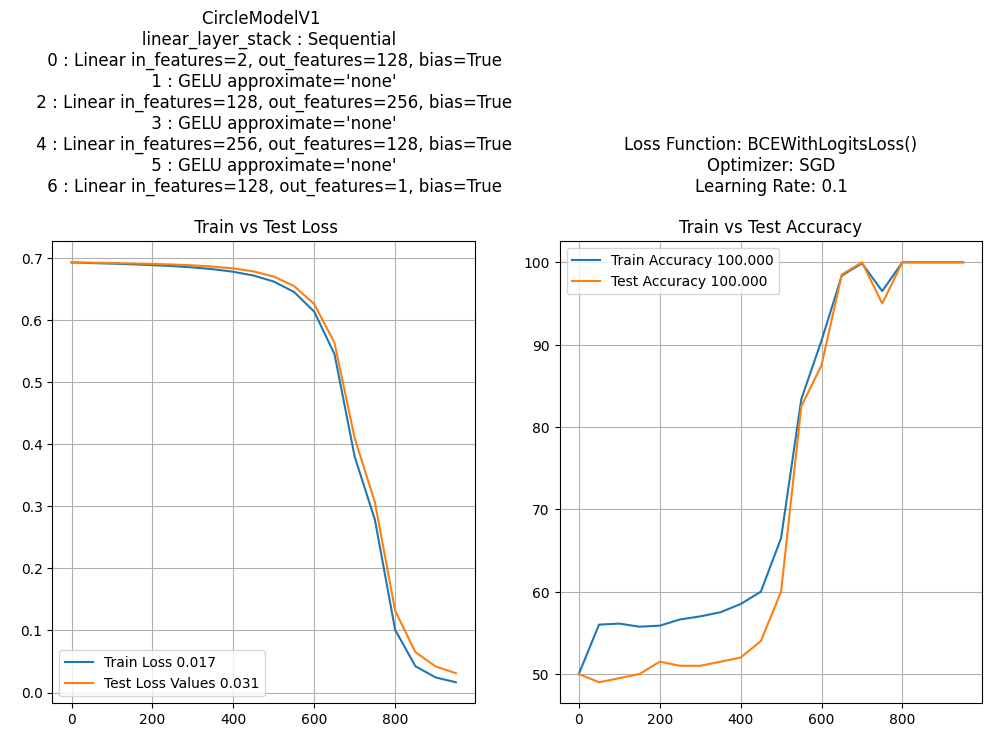

In [181]:
final_train_loss = loss_values[-1]
final_test_loss = test_loss_values[-1]
final_train_acc = acc_values[-1]
final_test_acc = test_acc_values[-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title(f"{model_0_cleaned}Train vs Test Loss")
plt.plot(epochs_count, np.array(torch.tensor(loss_values).numpy()), label=f"Train Loss {final_train_loss:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_loss_values).numpy()), label=f"Test Loss Values {final_test_loss:.3f}")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title(f"Loss Function: {loss_fn}\nOptimizer: {optimizer_class_name}\nLearning Rate: {learning_rate}\n\nTrain vs Test Accuracy")
plt.plot(epochs_count, np.array(torch.tensor(acc_values).numpy()), label=f"Train Accuracy {final_train_acc:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_acc_values).numpy()), label=f"Test Accuracy {final_test_acc:.3f}")
plt.legend();

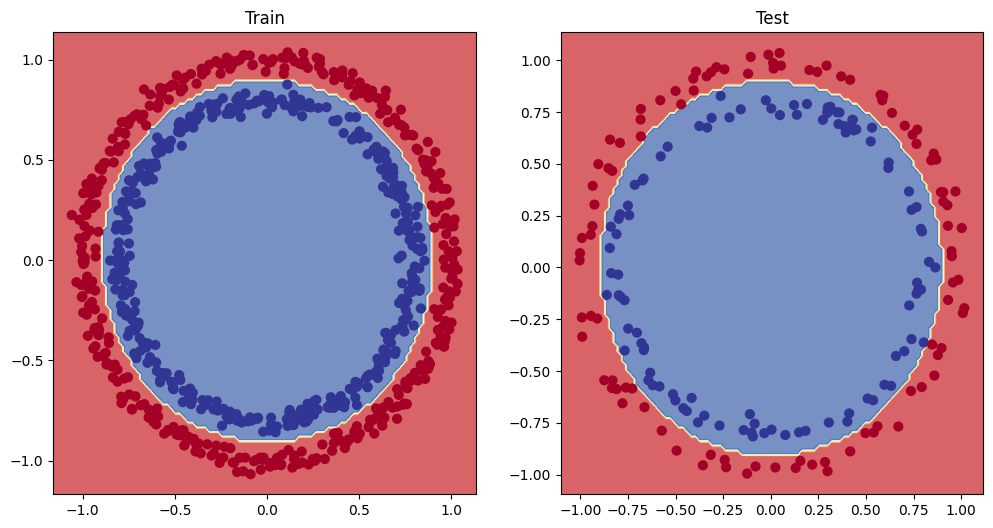

In [182]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

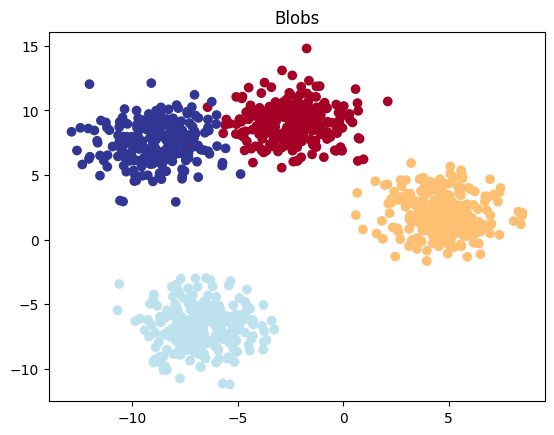

In [184]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
plt.title("Blobs")
plt.scatter(X_blob[:, 0],
            X_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu);



In [185]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


In [186]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

In [187]:
class BlobModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=64),
        nn.GELU(),
        nn.Linear(in_features=64, out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128, out_features=64),
        nn.GELU(),
        nn.Linear(in_features=64, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_1 = BlobModelV1(2, 4).to(device)
model_1_str = str(model_1)
model_1_cleaned = model_1_str.replace("(", " ").replace(")", " ")

In [188]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
optimizer_class_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]["lr"]

In [189]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, y_blob_train, = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_blob_train)

  y_pred = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_pred, dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_blob_test)

    test_pred = torch.softmax(test_logits, dim=1)
    test_pred = torch.argmax(test_pred, dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 50 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      acc_values.append(acc)
      test_acc_values.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.45608 | Acc: 39.38 | Test Loss: 1.02896 | Test Acc: 81.00
Epoch: 50 | Loss: 0.03494 | Acc: 99.12 | Test Loss: 0.02672 | Test Acc: 99.50
Epoch: 100 | Loss: 0.02815 | Acc: 99.12 | Test Loss: 0.01912 | Test Acc: 99.50
Epoch: 150 | Loss: 0.02577 | Acc: 99.25 | Test Loss: 0.01636 | Test Acc: 99.50
Epoch: 200 | Loss: 0.02436 | Acc: 99.25 | Test Loss: 0.01469 | Test Acc: 99.50
Epoch: 250 | Loss: 0.02336 | Acc: 99.25 | Test Loss: 0.01344 | Test Acc: 99.50
Epoch: 300 | Loss: 0.02257 | Acc: 99.38 | Test Loss: 0.01244 | Test Acc: 99.50
Epoch: 350 | Loss: 0.02192 | Acc: 99.38 | Test Loss: 0.01161 | Test Acc: 99.50
Epoch: 400 | Loss: 0.02137 | Acc: 99.38 | Test Loss: 0.01090 | Test Acc: 99.50
Epoch: 450 | Loss: 0.02091 | Acc: 99.38 | Test Loss: 0.01028 | Test Acc: 99.50
Epoch: 500 | Loss: 0.02051 | Acc: 99.38 | Test Loss: 0.00974 | Test Acc: 99.50
Epoch: 550 | Loss: 0.02014 | Acc: 99.38 | Test Loss: 0.00927 | Test Acc: 100.00
Epoch: 600 | Loss: 0.01982 | Acc: 99.38 | Test Loss: 0

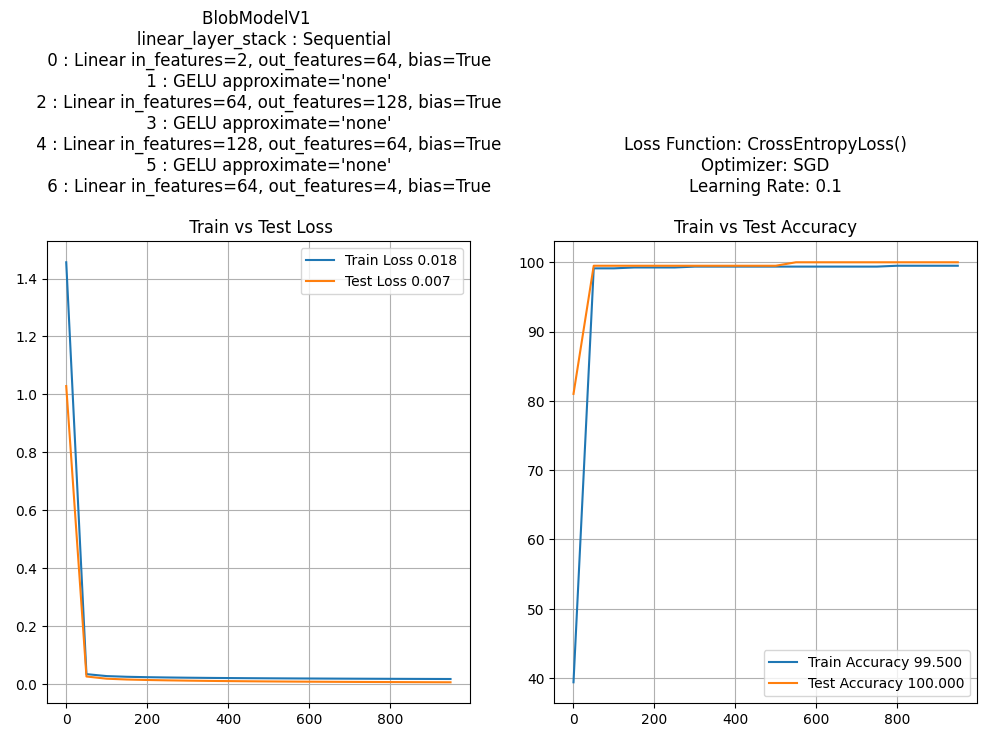

In [190]:
final_loss = loss_values[-1]
final_test_loss = test_loss_values[-1]
final_acc = acc_values[-1]
final_test_acc = test_acc_values[-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title(f"{model_1_cleaned}Train vs Test Loss")
plt.plot(epochs_count, np.array(torch.tensor(loss_values).numpy()), label=f"Train Loss {final_loss:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_loss_values).numpy()), label=f"Test Loss {final_test_loss:.3f}")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title(f"Loss Function: {loss_fn}\nOptimizer: {optimizer_class_name}\nLearning Rate: {learning_rate}\n\nTrain vs Test Accuracy")
plt.plot(epochs_count, np.array(torch.tensor(acc_values).numpy()), label=f"Train Accuracy {final_acc:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_acc_values).numpy()), label=f"Test Accuracy {final_test_acc:.3f}")
plt.legend();

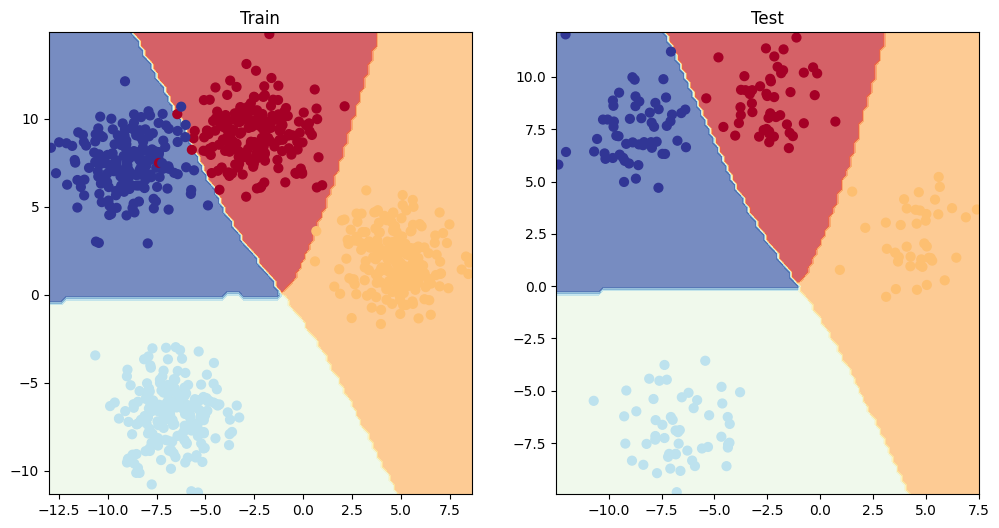

In [191]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)

In [192]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

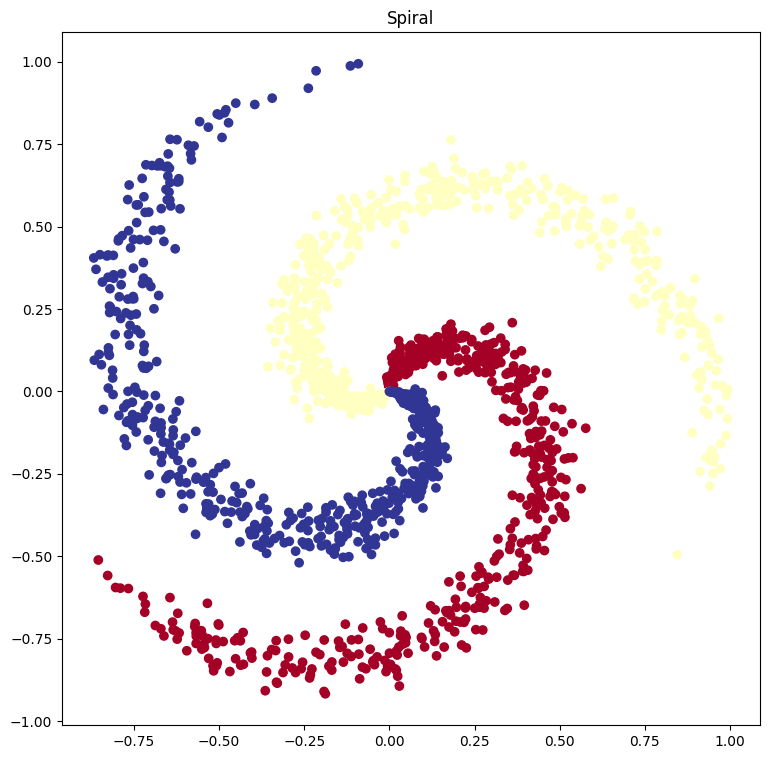

In [193]:
N = 500
D = 2
K = 3

X_spiral = np.zeros((N * K, D))
y_spiral = np.zeros(N * K, dtype="uint8")

for i in range(K):
  ix = range(N * i, N * (i + 1))
  r = np.linspace(0.0, 1, N)
  t = np.linspace(i * 4, (i + 1) * 4, N) + np.random.randn(N) * 0.2

  X_spiral[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
  y_spiral[ix] = i


plt.figure(figsize=(9, 9))
plt.title("Spiral")
plt.scatter(X_spiral[:, 0],
            X_spiral[:, 1],
            c=y_spiral,
            cmap=plt.cm.RdYlBu);

In [194]:
X_spiral = torch.from_numpy(X_spiral).type(torch.float)
y_spiral = torch.from_numpy(y_spiral).type(torch.LongTensor)

In [195]:
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral, y_spiral,
                                                                                test_size=0.2,
                                                                                random_state=42)

In [196]:
X_spiral_train.shape, X_spiral_test.shape, y_spiral_train.shape, y_spiral_test.shape

(torch.Size([1200, 2]),
 torch.Size([300, 2]),
 torch.Size([1200]),
 torch.Size([300]))

In [197]:
class SpiralModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=64),
        nn.GELU(),
        nn.Linear(in_features=64, out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128, out_features=256),
        nn.GELU(),
        nn.Linear(in_features=256, out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128, out_features=output_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_2 = SpiralModelV1(2, 3).to(device)
model_2_str = str(model_2)
model_2_cleaned = model_2_str.replace("(", " ").replace(")", " ")

In [198]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)
optimizer_class_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]["lr"]

In [199]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

epochs = 2000

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_spiral_train)

  y_pred = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_pred, dim=1)

  loss = loss_fn(y_logits, y_spiral_train)
  acc = accuracy_fn(y_spiral_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_spiral_test)

    test_pred = torch.softmax(test_logits, dim=1)
    test_pred = torch.argmax(test_pred, dim=1)

    test_loss = loss_fn(test_logits, y_spiral_test)
    test_acc = accuracy_fn(y_spiral_test, test_pred)

    if epoch % 100 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      acc_values.append(acc)
      test_loss_values.append(test_loss)
      test_acc_values.append(test_acc)
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.09883 | Acc: 34.50 | Test Loss: 1.10037 | Test acc: 28.67
Epoch: 100 | Loss: 1.08990 | Acc: 43.17 | Test Loss: 1.09304 | Test acc: 40.33
Epoch: 200 | Loss: 1.06581 | Acc: 55.25 | Test Loss: 1.06831 | Test acc: 52.00
Epoch: 300 | Loss: 0.88850 | Acc: 51.08 | Test Loss: 0.88653 | Test acc: 48.00
Epoch: 400 | Loss: 0.71948 | Acc: 57.58 | Test Loss: 0.72194 | Test acc: 55.67
Epoch: 500 | Loss: 0.64480 | Acc: 59.42 | Test Loss: 0.64707 | Test acc: 60.00
Epoch: 600 | Loss: 0.56306 | Acc: 67.83 | Test Loss: 0.55685 | Test acc: 66.67
Epoch: 700 | Loss: 0.45052 | Acc: 76.75 | Test Loss: 0.44008 | Test acc: 76.00
Epoch: 800 | Loss: 0.31971 | Acc: 86.67 | Test Loss: 0.30447 | Test acc: 88.67
Epoch: 900 | Loss: 0.20077 | Acc: 92.83 | Test Loss: 0.18068 | Test acc: 93.67
Epoch: 1000 | Loss: 0.16248 | Acc: 93.67 | Test Loss: 0.14877 | Test acc: 94.67
Epoch: 1100 | Loss: 0.10291 | Acc: 96.25 | Test Loss: 0.09561 | Test acc: 97.33
Epoch: 1200 | Loss: 0.07179 | Acc: 97.25 | Test Loss

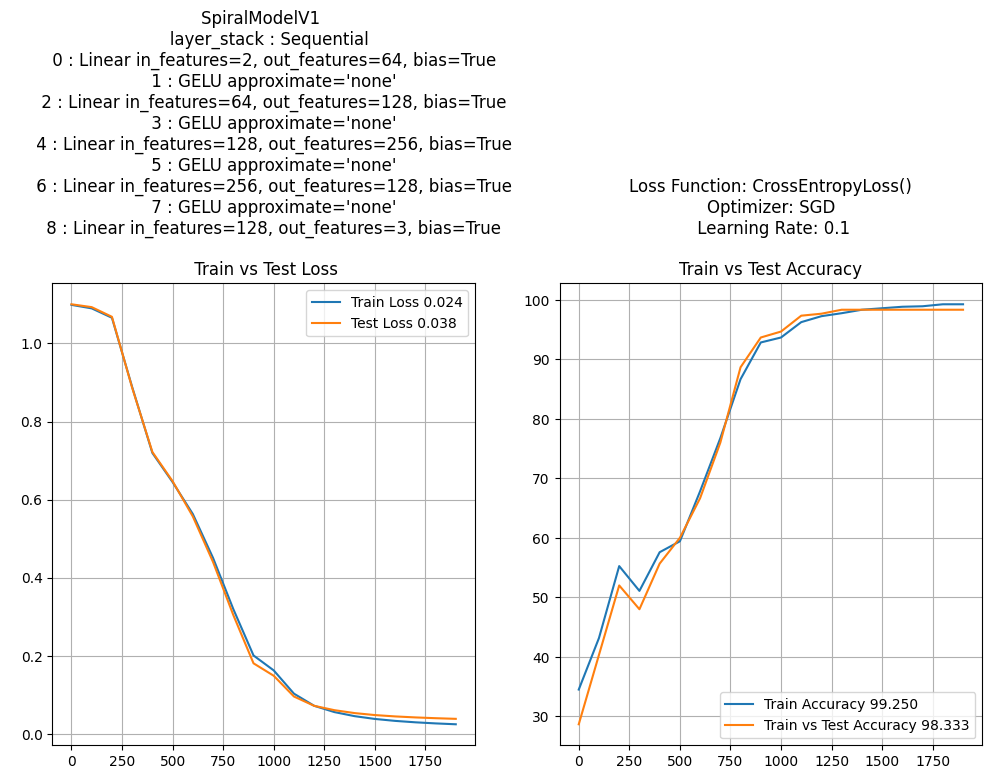

In [200]:
final_train_loss = loss_values[-1]
final_test_loss = test_loss_values[-1]
final_acc = acc_values[-1]
final_test_acc = test_acc_values[-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title(f"{model_2_cleaned}Train vs Test Loss")
plt.plot(epochs_count, np.array(torch.tensor(loss_values).numpy()), label=f"Train Loss {final_train_loss:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_loss_values).numpy()), label=f"Test Loss {final_test_loss:.3f}")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title(f"Loss Function: {loss_fn}\nOptimizer: {optimizer_class_name}\n Learning Rate: {learning_rate}\n\nTrain vs Test Accuracy")
plt.plot(epochs_count, np.array(torch.tensor(acc_values).numpy()), label=f"Train Accuracy {final_acc:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_acc_values).numpy()), label=f"Train vs Test Accuracy {final_test_acc:.3f}")
plt.legend();

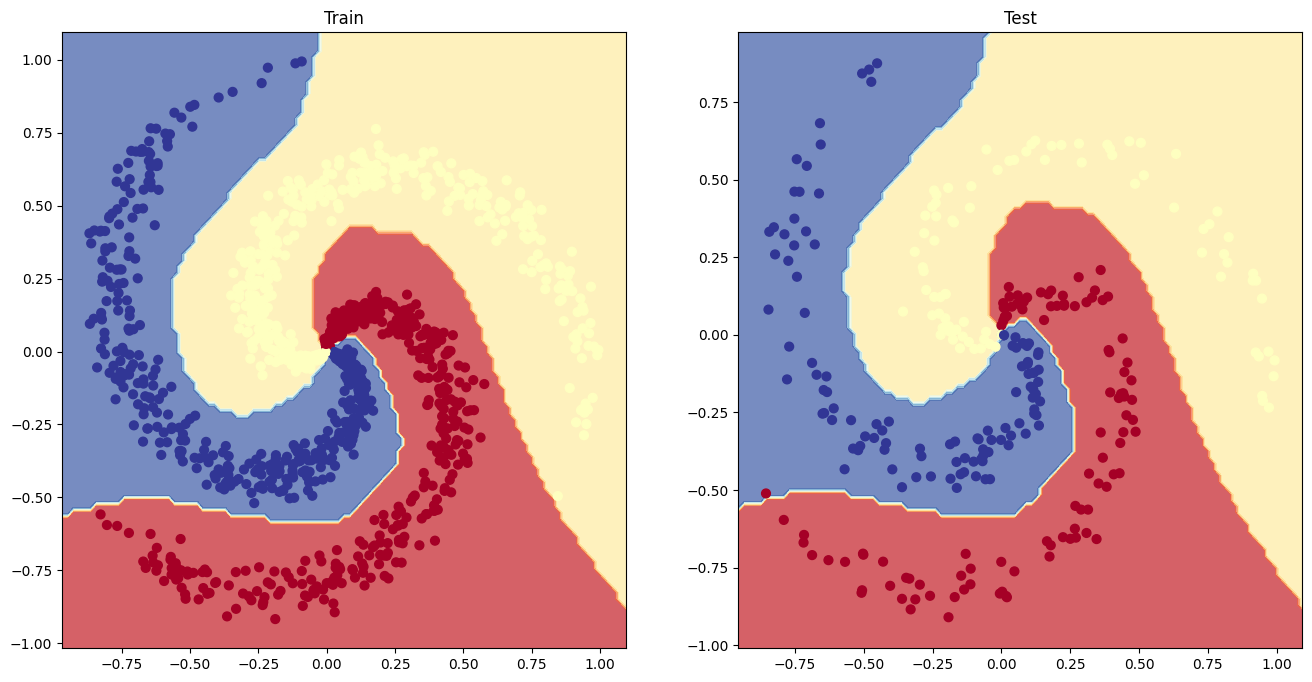

In [201]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_spiral_train, y_spiral_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_spiral_test, y_spiral_test)

In [202]:
import sklearn
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import requests
from pathlib import Path
import numpy as np

In [203]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

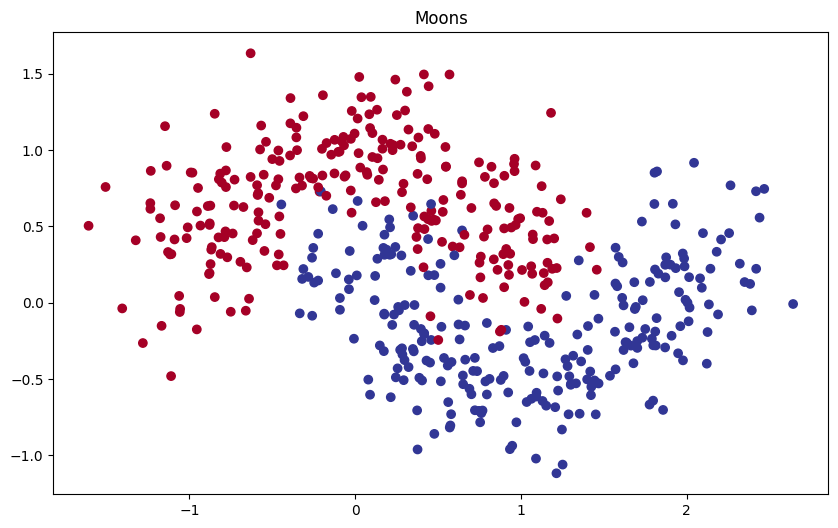

In [204]:
X_moon, y_moon = make_moons(n_samples=500,
                            shuffle=True,
                            noise=0.25,
                            random_state=42)

plt.figure(figsize=(10, 6))
plt.title("Moons")
plt.scatter(X_moon[:, 0],
            X_moon[:, 1],
            c=y_moon,
            cmap=plt.cm.RdYlBu);

In [205]:
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)

In [206]:
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon,
                                                                        y_moon,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [207]:
X_moon_train.shape, X_moon_test.shape, y_moon_train.shape, y_moon_test.shape

(torch.Size([400, 2]),
 torch.Size([100, 2]),
 torch.Size([400]),
 torch.Size([100]))

In [208]:
class MoonModelV1(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=128),
        nn.SiLU(),
        nn.Linear(in_features=128, out_features=256),
        nn.SiLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.SiLU(),
        nn.Linear(in_features=128, out_features=output_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_3 = MoonModelV1(2, 1).to(device)
model_3_str = str(model_3)
model_3_cleaned = model_3_str.replace("(", " ").replace(")", " ")

In [209]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.075)
optimizer_class_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]["lr"]

In [210]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_moon_train, y_moon_train = X_moon_train.to(device), y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)

epochs_count = []
loss_values = []
test_loss_values = []
acc_values = []
test_acc_values = []

epochs = 3000

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_moon_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_moon_train)
  acc = accuracy_fn(y_moon_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_moon_test).squeeze()

    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_moon_test)
    test_acc = accuracy_fn(y_moon_test, test_preds)

    if epoch % 150 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      acc_values.append(acc)
      test_loss_values.append(test_loss)
      test_acc_values.append(test_acc)

      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69156 | Acc: 48.25 | Test Loss: 0.68709 | Test Acc: 57.00
Epoch: 150 | Loss: 0.32789 | Acc: 83.25 | Test Loss: 0.33232 | Test Acc: 85.00
Epoch: 300 | Loss: 0.29726 | Acc: 85.75 | Test Loss: 0.31620 | Test Acc: 86.00
Epoch: 450 | Loss: 0.29519 | Acc: 85.75 | Test Loss: 0.31511 | Test Acc: 86.00
Epoch: 600 | Loss: 0.29318 | Acc: 85.75 | Test Loss: 0.31415 | Test Acc: 86.00
Epoch: 750 | Loss: 0.29069 | Acc: 86.00 | Test Loss: 0.31282 | Test Acc: 86.00
Epoch: 900 | Loss: 0.28734 | Acc: 86.00 | Test Loss: 0.31089 | Test Acc: 86.00
Epoch: 1050 | Loss: 0.28248 | Acc: 86.00 | Test Loss: 0.30788 | Test Acc: 86.00
Epoch: 1200 | Loss: 0.27473 | Acc: 86.25 | Test Loss: 0.30276 | Test Acc: 86.00
Epoch: 1350 | Loss: 0.26089 | Acc: 86.75 | Test Loss: 0.29294 | Test Acc: 86.00
Epoch: 1500 | Loss: 0.23365 | Acc: 89.00 | Test Loss: 0.27193 | Test Acc: 86.00
Epoch: 1650 | Loss: 0.18667 | Acc: 92.25 | Test Loss: 0.23059 | Test Acc: 89.00
Epoch: 1800 | Loss: 0.14366 | Acc: 94.75 | Test L

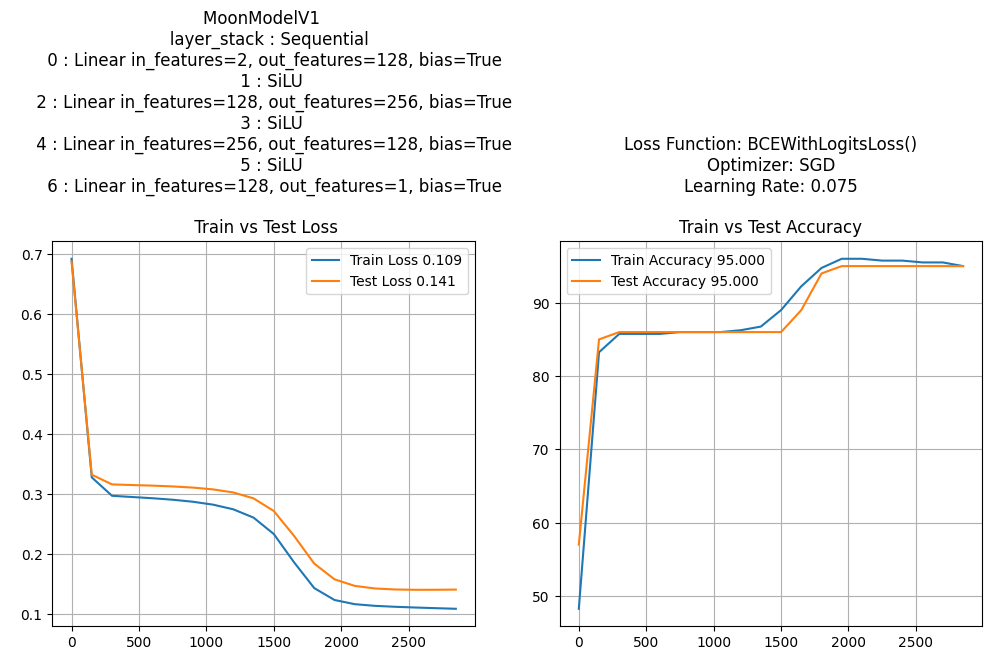

In [211]:
final_train_loss = loss_values[-1]
final_test_loss = test_loss_values[-1]
final_acc = acc_values[-1]
final_test_acc = test_acc_values[-1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title(f"{model_3_cleaned}Train vs Test Loss")
plt.plot(epochs_count, np.array(torch.tensor(loss_values).numpy()), label=f"Train Loss {final_train_loss:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_loss_values).numpy()), label=f"Test Loss {final_test_loss:.3f}")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title(f"Loss Function: {loss_fn}\nOptimizer: {optimizer_class_name}\nLearning Rate: {learning_rate}\n\nTrain vs Test Accuracy")
plt.plot(epochs_count, np.array(torch.tensor(acc_values).numpy()), label=f"Train Accuracy {final_acc:.3f}")
plt.plot(epochs_count, np.array(torch.tensor(test_acc_values).numpy()), label=f"Test Accuracy {final_test_acc:.3f}")
plt.legend();


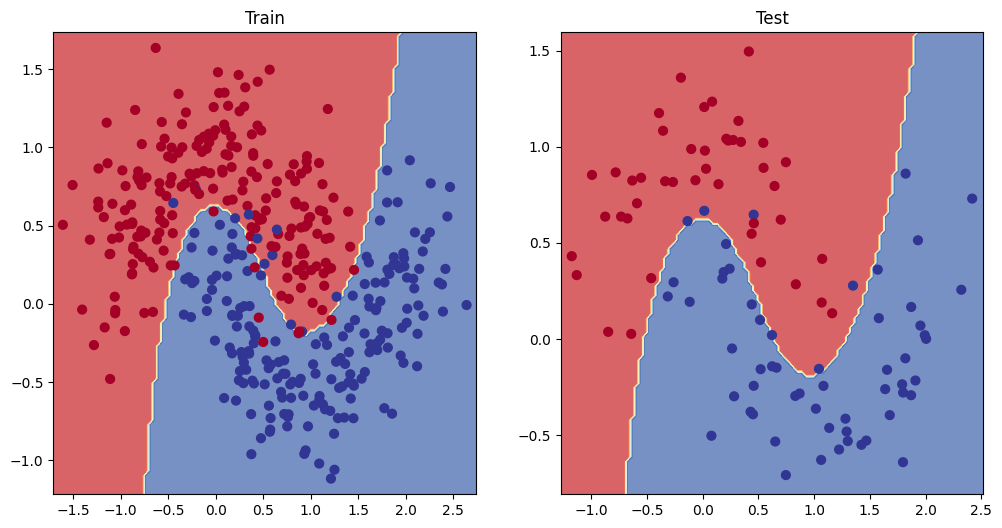

In [212]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_moon_test, y_moon_test)